# 0. Install and Import dependencies

In [177]:
# !pip install tensorflow-gpu==1.15.0 tensorflow==1.15.0 stable-baselines gym-anytrading gym

In [178]:
# Gym stuff
import gymnasium as gym
import gym_anytrading

# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3, DQN, HER

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import quantstats as qs

In [179]:
# Specify parameters
STOCK_NAME = 'TSLA'

# Window size for training
TRAIN_WINDOW_SIZE = 10
TRAIN_START = '2020-01-01'
TRAIN_END = '2022-12-31'

TEST_WINDOW_SIZE = 10

# Indicator parameters
SMA_PERIOD = 10

# 1. Get Data

In [180]:
import yfinance as yf

df = yf.Ticker(STOCK_NAME)
df = df.history(period="max")
df = df.loc[TRAIN_START:, ['Open', 'High', 'Low', 'Close', 'Volume']]
print(df.shape)
df.head()

(1083, 5)


,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02 00:00:00-05:00,28.299999,28.713333,28.114000,28.684000,142981500
2020-01-03 00:00:00-05:00,29.366667,30.266666,29.128000,29.534000,266677500
2020-01-06 00:00:00-05:00,29.364668,30.104000,29.333332,30.102667,151995000
2020-01-07 00:00:00-05:00,30.760000,31.441999,30.224001,31.270666,268231500
2020-01-08 00:00:00-05:00,31.580000,33.232666,31.215334,32.809334,467164500


In [181]:
TRAIN_ENV_FRAME_BOUND = (TRAIN_WINDOW_SIZE, df[TRAIN_START:TRAIN_END].shape[0])
TEST_ENV_FRAME_BOUND = (df[TRAIN_START:TRAIN_END].shape[0], df.shape[0])

In [182]:
df[TRAIN_START:TRAIN_END]

,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02 00:00:00-05:00,28.299999,28.713333,28.114000,28.684000,142981500
2020-01-03 00:00:00-05:00,29.366667,30.266666,29.128000,29.534000,266677500
2020-01-06 00:00:00-05:00,29.364668,30.104000,29.333332,30.102667,151995000
2020-01-07 00:00:00-05:00,30.760000,31.441999,30.224001,31.270666,268231500
2020-01-08 00:00:00-05:00,31.580000,33.232666,31.215334,32.809334,467164500
...,...,...,...,...,...
2022-12-23 00:00:00-05:00,126.370003,128.619995,121.019997,123.150002,166989700
2022-12-27 00:00:00-05:00,117.500000,119.669998,108.760002,109.099998,208643400
2022-12-28 00:00:00-05:00,110.349998,116.269997,108.239998,112.709999,221070500


# 2.1 Add Custom Indicators

## 2.1.3. Calculate SMA, RSI and OBV

In [183]:
from gym_anytrading.envs import StocksEnv
from finta import TA

In [184]:
# Add SMA
df['SMA'] = TA.SMA(df, period=SMA_PERIOD)  # Make sure SMA_PERIOD is defined

# Add EMA
df['EMA'] = TA.EMA(df, period=20)  # You can adjust the period as needed

# Add RSI (you already have this)
df['RSI'] = TA.RSI(df)

# Add MACD
df['MACD'] = TA.MACD(df)['MACD']

# Add Bollinger Bands
bollinger = TA.BBANDS(df)
df['BB_UPPER'] = bollinger['BB_UPPER']
df['BB_LOWER'] = bollinger['BB_LOWER']
df['BB_MIDDLE'] = bollinger['BB_MIDDLE'] 

# Add Stochastic Oscillator
# stoch = TA.STOCH(df)
# df['STOCH_K'] = stoch['%K']
# df['STOCH_D'] = stoch['%D']

# Add Average True Range
df['ATR'] = TA.ATR(df)

# Add OBV (you already have this)
df['OBV'] = TA.OBV(df)

# Handle NaN values
df.fillna(0, inplace=True)

In [185]:
df

,Open,High,Low,Close,Volume,SMA,EMA,RSI,MACD,BB_UPPER,BB_LOWER,BB_MIDDLE,ATR,OBV
Date,,,,,,,,,,,,,,
2020-01-02 00:00:00-05:00,28.299999,28.713333,28.114000,28.684000,142981500,0.000000,28.684000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
2020-01-03 00:00:00-05:00,29.366667,30.266666,29.128000,29.534000,266677500,0.000000,29.130250,100.000000,0.019071,0.000000,0.000000,0.000000,0.000000,2.666775e+08
2020-01-06 00:00:00-05:00,29.364668,30.104000,29.333332,30.102667,151995000,0.000000,29.487316,100.000000,0.041934,0.000000,0.000000,0.000000,0.000000,4.186725e+08
2020-01-07 00:00:00-05:00,30.760000,31.441999,30.224001,31.270666,268231500,0.000000,30.002141,100.000000,0.093475,0.000000,0.000000,0.000000,0.000000,6.869040e+08
2020-01-08 00:00:00-05:00,31.580000,33.232666,31.215334,32.809334,467164500,0.000000,30.681177,100.000000,0.180741,0.000000,0.000000,0.000000,0.000000,1.154068e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-16 00:00:00-04:00,156.740005,158.190002,153.750000,157.110001,97000000,169.025000,171.280410,35.977768,-4.504317,182.540264,160.324739,171.432501,7.633575,1.461472e+10
2024-04-17 00:00:00-04:00,157.639999,158.330002,153.779999,155.449997,82439700,167.731999,169.772752,34.989351,-5.231105,183.849055,157.428947,170.639001,7.536433,1.453228e+10
2024-04-18 00:00:00-04:00,151.250000,152.199997,148.699997,149.929993,96098800,165.613998,167.882965,31.855324,-6.181254,185.243260,153.461741,169.352500,7.695004,1.443618e+10


## 2.1.4. Create New Environments

In [186]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, :].to_numpy()[start:end]
    return prices, signal_features

In [187]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals

# 3. Build Environment and Train

In [188]:
env2 = MyCustomEnv(df=df, frame_bound=TRAIN_ENV_FRAME_BOUND, window_size=TRAIN_WINDOW_SIZE)
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

In [189]:
print()
print("custom_env information:")
print("> shape:", env2.unwrapped.shape)
print("> df.shape:", env2.unwrapped.df.shape)
print("> prices.shape:", env2.unwrapped.prices.shape)
print("> signal_features.shape:", env2.unwrapped.signal_features.shape)
print("> max_possible_profit:", env2.unwrapped.max_possible_profit())


custom_env information:
> shape: (10, 14)
> df.shape: (1083, 14)
> prices.shape: (756,)
> signal_features.shape: (756, 14)
> max_possible_profit: 235144.2459428843


In [190]:
env2.signal_features

array([[2.82999992e+01, 2.87133331e+01, 2.81140003e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.93666668e+01, 3.02666664e+01, 2.91280003e+01, ...,
        0.00000000e+00, 0.00000000e+00, 2.66677500e+08],
       [2.93646679e+01, 3.01040001e+01, 2.93333321e+01, ...,
        0.00000000e+00, 0.00000000e+00, 4.18672500e+08],
       ...,
       [1.10349998e+02, 1.16269997e+02, 1.08239998e+02, ...,
        1.58104000e+02, 1.01571415e+01, 1.08646500e+10],
       [1.20389999e+02, 1.23570000e+02, 1.17500000e+02, ...,
        1.54460000e+02, 1.04942845e+01, 1.10865733e+10],
       [1.19949997e+02, 1.24480003e+02, 1.19750000e+02, ...,
        1.50884000e+02, 1.01792848e+01, 1.12443506e+10]])

In [191]:
env2.signal_features.shape

(756, 14)

In [192]:
# model = A2C('MlpPolicy', env, verbose=0) 
# model.learn(total_timesteps=10000)

In [193]:
from sb3_contrib import RecurrentPPO

model = RecurrentPPO("MlpLstmPolicy", env, verbose=1, seed=2023)
model.learn(total_timesteps=10) # to be changed

Using cpu device


----------------------------
| time/              |     |
|    fps             | 342 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 128 |
----------------------------


# 4. Evaluation

In [194]:
env = MyCustomEnv(df=df, frame_bound=TEST_ENV_FRAME_BOUND, window_size=TEST_WINDOW_SIZE)
observation, info = env.reset()
while True: 
    observation = observation.reshape(TRAIN_WINDOW_SIZE, env2.signal_features.shape[1]) 
    observation = observation[np.newaxis, ...]
    action, _states = model.predict(observation)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    if done:
        print("info", info)
        break

info {'total_reward': -31.859947204589844, 'total_profit': 0.25073653815539027, 'position': <Positions.Long: 1>}


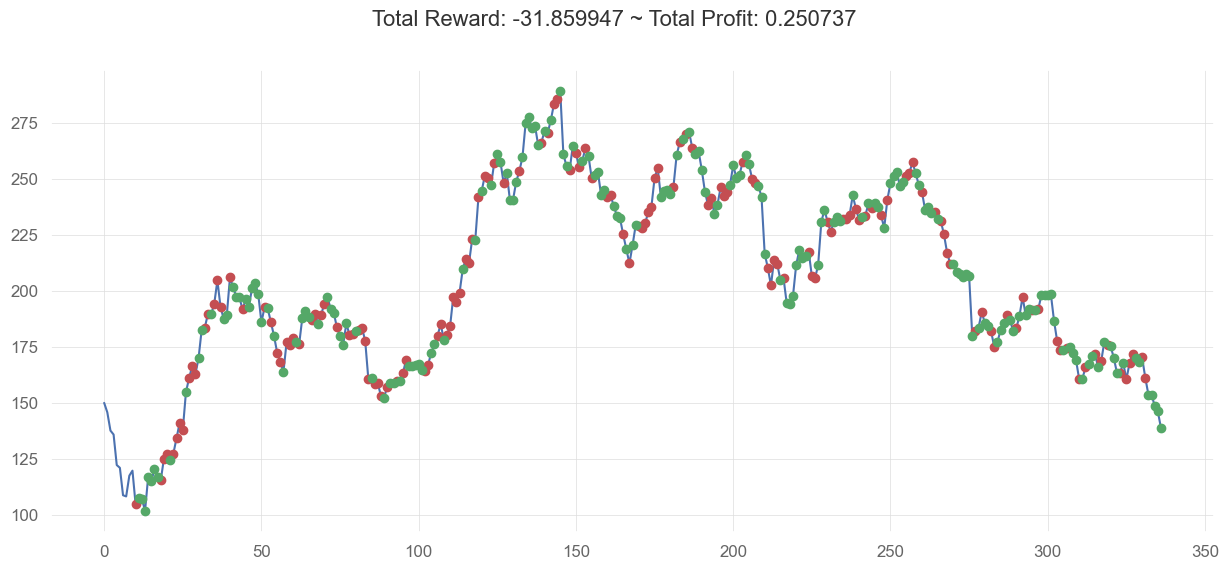

In [195]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

# 5. QuantStats

                           Strategy
-------------------------  ----------
Start Period               2023-01-05
End Period                 2024-04-22
Risk-Free Rate             0.0%
Time in Market             26.0%

Cumulative Return          -74.93%
CAGR﹪                     -52.15%

Sharpe                     -2.36
Prob. Sharpe Ratio         0.1%
Smart Sharpe               -2.31
Sortino                    -2.65
Smart Sortino              -2.6
Sortino/√2                 -1.87
Smart Sortino/√2           -1.84
Omega                      0.43

Max Drawdown               -80.35%
Longest DD Days            426
Volatility (ann.)          41.59%
Calmar                     -0.65
Skew                       -2.18
Kurtosis                   12.81

Expected Daily %           -0.42%
Expected Monthly %         -8.28%
Expected Yearly %          -49.93%
Kelly Criterion            -49.74%
Risk of Ruin               0.0%
Daily Value-at-Risk        -4.7%
Expected Shortfall (cVaR)  -4.7%

Max Consecutive

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-02-22,2024-04-22,2024-04-22,425,-80.345994,-77.609738


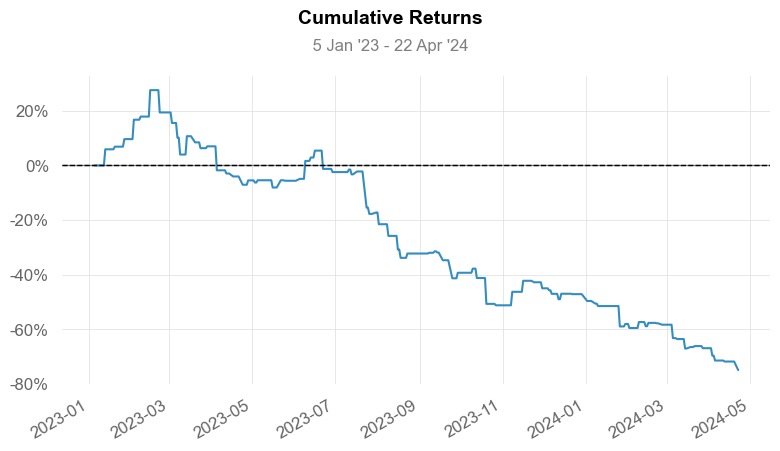

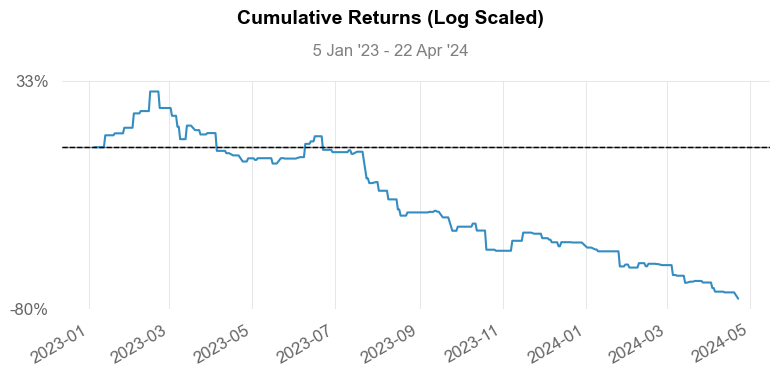

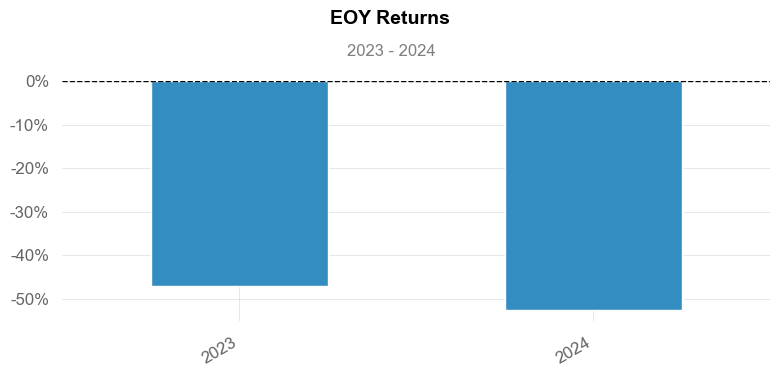

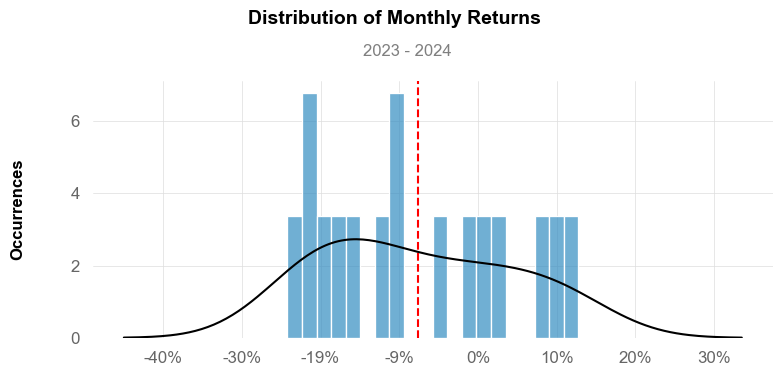

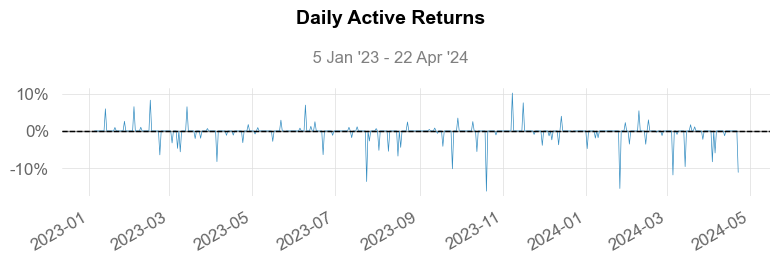

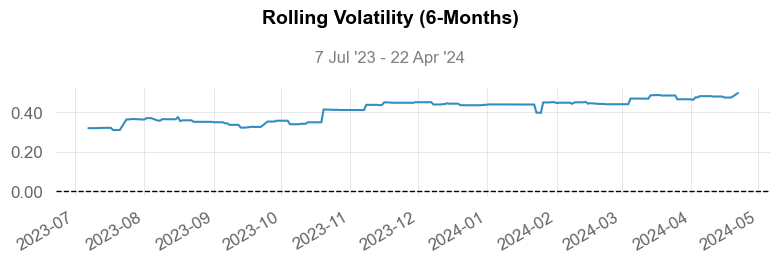

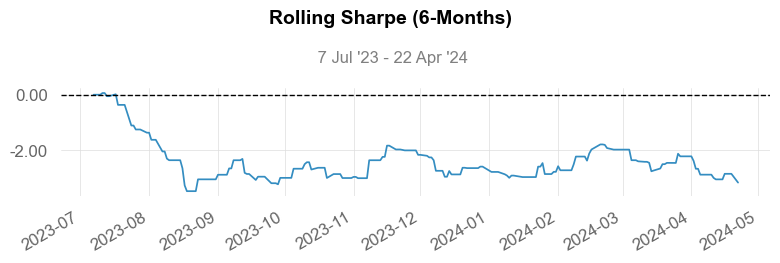

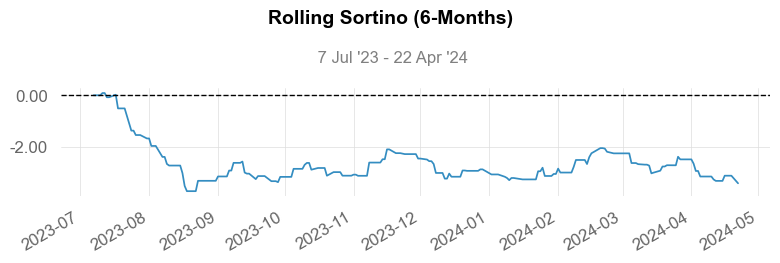

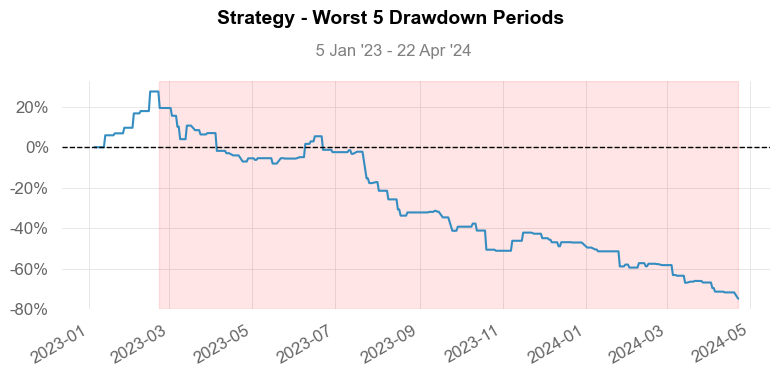

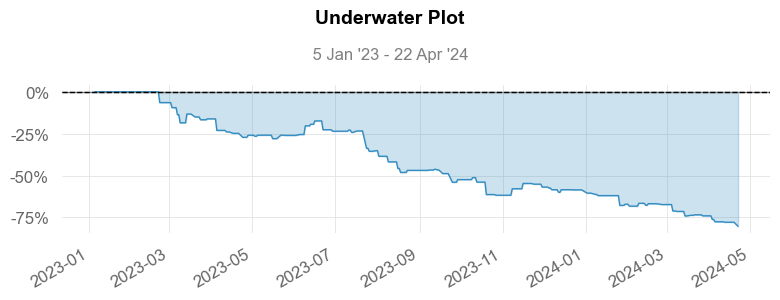

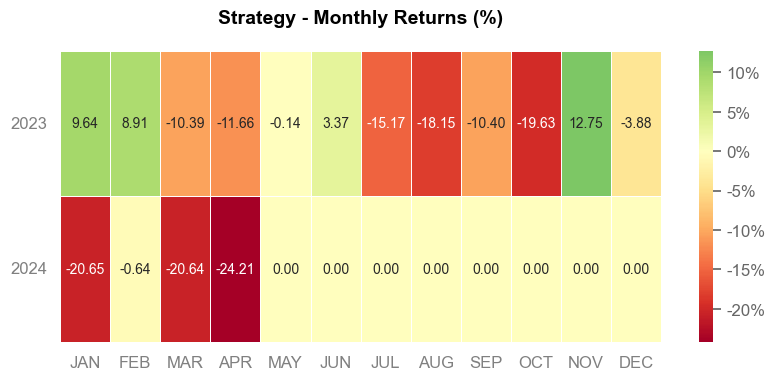

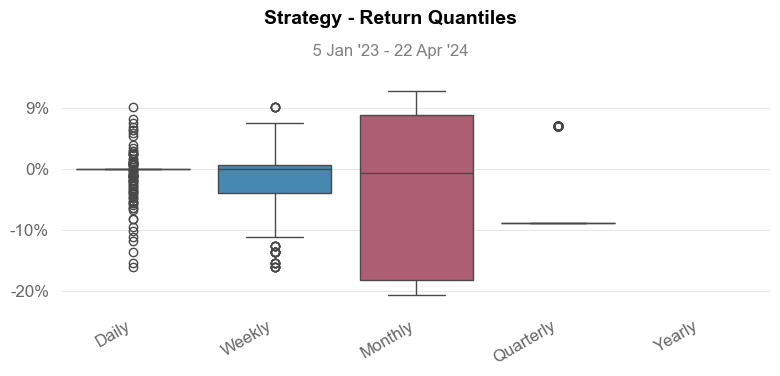

In [196]:
qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df.index[TEST_ENV_FRAME_BOUND[0] + 1:TEST_ENV_FRAME_BOUND[1]])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)

In [197]:
qs.reports.html(returns, output=f"quantstats-{STOCK_NAME}.html")